In [1]:
import os
import re
import string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from indoNLP.preprocessing import (emoji_to_words, remove_html, remove_url, 
                                   replace_slang, replace_word_elongation, 
                                   remove_stopwords)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

In [2]:
local = "../data/"
if os.path.isdir(local):
    main_dir = local
else:
    main_dir = "https://raw.githubusercontent.com/Hyuto/skripsi/master/data/"

In [3]:
data = pd.read_csv(main_dir + "sample-data.csv")
data.head()

,date,url,user,content,label
0,2021-09-02 01:39:05+00:00,https://twitter.com/no_nykrstnd/status/1433243...,no_nykrstnd,"-Dari hasil monitoring, calon Vaksin Merah Put...",0.0
1,2021-07-15 06:09:36+00:00,https://twitter.com/DakwahMujahidah/status/141...,DakwahMujahidah,[PODCAST] Ngomong Politik - Ilusi Penguatan Ke...,0.0
2,2021-07-05 08:57:50+00:00,https://twitter.com/gamisjohor/status/14119725...,gamisjohor,3. GAMIS menyambut baik saranan daripada YAB P...,2.0
3,2021-09-09 09:17:58+00:00,https://twitter.com/inyesaw/status/14358952423...,inyesaw,@txtdaribogor Abis vaksin terbitlah positif covid,4.0
4,2021-01-02 04:37:14+00:00,https://twitter.com/pringgolakseno/status/1345...,pringgolakseno,"Gambling, vaksin sama ga divaksin.\nGa divaksi...",4.0


In [4]:
data.dropna(inplace=True)
data["date"] = pd.to_datetime(data["date"]).dt.tz_localize(None)
data["label"] = data["label"].astype(int)
data = data[data["label"] > 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359 entries, 2 to 996
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     359 non-null    datetime64[ns]
 1   url      359 non-null    object        
 2   user     359 non-null    object        
 3   content  359 non-null    object        
 4   label    359 non-null    int32         
dtypes: datetime64[ns](1), int32(1), object(3)
memory usage: 15.4+ KB


In [5]:
STEMMER = StemmerFactory().create_stemmer()

def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text, flags=re.UNICODE)  # remove whitespace
    text = emoji_to_words(text)  # remove emoji
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("ascii")
    text = remove_html(text)  # remove html tags
    text = remove_url(text)  # remove url
    text = replace_word_elongation(text)
    text = replace_slang(text) # replace slang words
    text = remove_stopwords(text)
    text = text.translate(str.maketrans("", "", string.digits))  # remove numbers
    text = text.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )  # remove punctuation
    text = " ".join(text.split())
    text = STEMMER.stem(text)
    return " ".join(text.split())

In [6]:
data["cleaned"] = [preprocessing(x) for x in tqdm(data["content"].values)]

  0%|          | 0/359 [00:00<?, ?it/s]

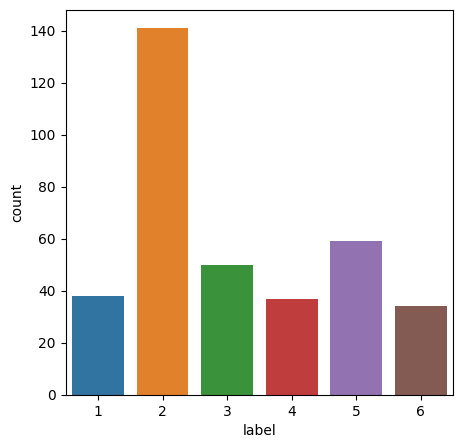

In [7]:
plt.figure(figsize=(5, 5))
sns.countplot(data=data, x="label")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import *

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data["cleaned"].values, data["label"].values, test_size = 0.2,
                                                    random_state=2022, stratify=data["label"].values)

In [10]:
pipe = Pipeline([
    ("tf-idf", TfidfVectorizer(max_features=3000)),
    ("svm", SVC(kernel="linear")),
])
pipe.fit(x_train, y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer(max_features=3000)),
                ('svm', SVC(kernel='linear'))])

In [11]:
accuracy_score(y_test, pipe.predict(x_test))

0.4166666666666667

In [12]:
f1_score(y_test, pipe.predict(x_test), average=None)

array([0.        , 0.61176471, 0.15384615, 0.        , 0.31578947,
       0.        ])